In [24]:
from google.colab import drive
drive.mount('/content/colabdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/colabdrive


In [0]:
import os
os.chdir("/content/colabdrive/My Drive")  

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0'

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

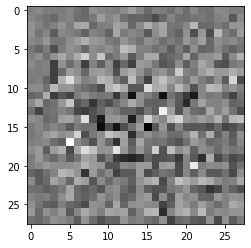

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00267718]], shape=(1, 1), dtype=float32)


In [0]:
discriminator.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_95 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)            

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every #15 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

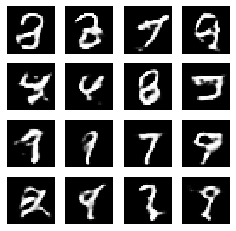

In [0]:
train(train_dataset, EPOCHS)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

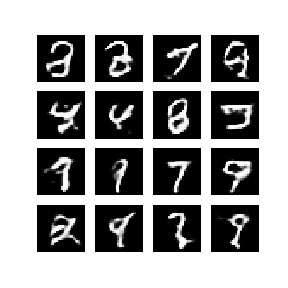

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

# Implement  our  own  GAN  with  CNN  layers  on  MNIST  data.

In [0]:
from keras.layers import UpSampling2D

Using TensorFlow backend.


In [0]:
def make_new_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    model.add(layers.Dropout(0.4))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [0]:
new_generator = make_new_generator_model()
new_generator.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_77 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_26 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_75 (Conv2DT (None, 14, 14, 128)     

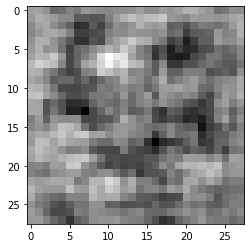

In [0]:
noise = tf.random.normal([1, 100])
new_generated_image = new_generator(noise, training=False)

plt.imshow(new_generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_new_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))

    return model

In [0]:
new_discriminator = make_new_discriminator_model()
new_discriminator.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 256)       

In [0]:
new_decision = new_discriminator(new_generated_image)
print (new_decision)

tf.Tensor([[0.5067799]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=new_generator,
                                 discriminator=new_discriminator)

In [0]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      new_generated_images = new_generator(noise, training=True)

      real_output = new_discriminator(images, training=True)
      fake_output = new_discriminator(new_generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, new_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, new_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, new_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, new_discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(new_generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(new_generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

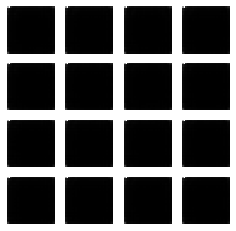

Time for epoch 18 is 40.25473141670227 sec


KeyboardInterrupt: ignored

In [0]:
train(train_dataset, EPOCHS)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan_new_architecture.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

# Implement your own GAN with SVHN data


## import data


In [22]:
import os
os.getcwd()

'/content'

In [0]:
from scipy.io import loadmat 
train_images = loadmat('train_32x32.mat')

In [0]:
train_images = train_images['X']

In [0]:
#Transpose to image shape
train_images = train_images.transpose((3,0,1,2))

In [0]:
import matplotlib.pyplot as plt
def plot_images(img, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])

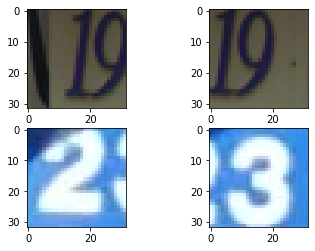

In [19]:
plot_images(train_images,2,2)

## Preprocessing


### Transfer into grayscale

In [0]:
# Let's use grayscale iamges
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [0]:
train_images = rgb2gray(train_images).astype(np.float32)

### Normalization 

In [0]:
def Normalization(data):   
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data = (data - mean) / std
    return data

In [0]:
train_images = Normalization(train_images)

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

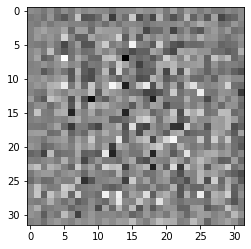

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [28]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [0]:

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (7, 7), strides=(1, 1), padding='same',input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1))

    return model

  

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00453297]], shape=(1, 1), dtype=float32)


In [36]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch multiple                  4         
_________________________________________________________________
conv2d (Conv2D)              multiple                  1600      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization_4 (Batch multiple                  128       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    multiple                 

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every #15 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

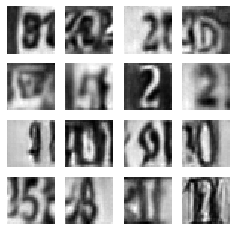

In [35]:
train(train_dataset, EPOCHS)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [0]:
import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

# WGAN

In [1]:
import os
os.environ['KERAS_BACKEND']='theano' # 也可以使用 tensorflow
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda'


import keras.backend as K
K.set_image_data_format('channels_first')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02)

Using Theano backend.
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [0]:
def DCGAN_D(isize, nz, nc, ndf, n_extra_layers=0):
    _ = inputs = Input(shape=(nc, isize, isize))
    _ = ZeroPadding2D(name = 'initial.padding.{0}'.format(nc))(_)
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, 
                        name = 'initial.conv.{0}-{1}'.format(nc, ndf)             
                        ) (_)
    _ = LeakyReLU(alpha=0.2, name = 'initial.relu.{0}'.format(ndf))(_)
    csize, cndf = isize // 2, ndf
    while csize > 5:
        in_feat = cndf
        out_feat = cndf*2
        _ = ZeroPadding2D(name = 'pyramid.{0}.padding'.format(in_feat))(_)
        _ = Conv2D(filters=out_feat, kernel_size=4, strides=2, use_bias=False, 
                        kernel_initializer = conv_init, 
                        name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat)
                        ) (_)        
        _ = BatchNormalization(name = 'pyramid.{0}.batchnorm'.format(out_feat), 
                                   axis=1, epsilon=1.01e-5)(_, training=1)        
        _ = LeakyReLU(alpha=0.2, name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cndf = csize//2, cndf*2
    _ = Conv2D(filters=1, kernel_size=csize, strides=1, use_bias=False,                        
                        name = 'final.{0}-{1}.conv'.format(cndf, 1)         
                        ) (_)
    outputs = Flatten()(_)
    return Model(inputs=inputs, outputs=outputs)

In [0]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        tisize = tisize // 2
    _ = inputs = Input(shape=(nz,))
    _ = Reshape((nz, 1,1))(_)
    _ = Conv2DTranspose(filters=cngf, kernel_size=tisize, strides=1, use_bias=False,
                           kernel_initializer = conv_init, 
                           name = 'initial.{0}-{1}.convt'.format(nz, cngf))(_)
    _ = BatchNormalization(axis=1, epsilon=1.01e-5, name = 'initial.{0}.batchnorm'.format(cngf))(_, training=1)
    _ = Activation("relu", name = 'initial.{0}.relu'.format(cngf))(_)
    csize, cndf = tisize, cngf
    
    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = Conv2DTranspose(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat)             
                        ) (_)
        _ = Cropping2D(cropping=1, name = 'pyramid.{0}.cropping'.format(in_feat) )(_)
        _ = BatchNormalization(axis=1, epsilon=1.01e-5, name = 'pyramid.{0}.batchnorm'.format(out_feat))(_, training=1)        
        _ = Activation("relu", name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cngf = csize*2, cngf//2
    _ = Conv2DTranspose(filters=nc, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.convt'.format(cngf, nc)
                        )(_)
    _ = Cropping2D(cropping=1, name = 'final.{0}.cropping'.format(nc) )(_)
    outputs = Activation("tanh", name = 'final.{0}.tanh'.format(nc))(_)
    return Model(inputs=inputs, outputs=outputs)

In [0]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5

imageSize = 32
batchSize = 64
lrD = 0.0003 
lrG = 0.0003 
clamp_lower, clamp_upper = -0.01, 0.01

In [14]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
netG.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1, 1)         0         
_________________________________________________________________
initial.100-256.convt (Conv2 (None, 256, 4, 4)         409600    
_________________________________________________________________
initial.256.batchnorm (Batch (None, 256, 4, 4)         1024      
_________________________________________________________________
initial.256.relu (Activation (None, 256, 4, 4)         0         
_________________________________________________________________
pyramid.256-128.convt (Conv2 (None, 128, 10, 10)       524288    
_________________________________________________________________
pyramid.256.cropping (Croppi (None, 128, 8, 8)         0   

In [9]:
netD = DCGAN_D(imageSize, nz, nc, ndf, n_extra_layers)
netD.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 32, 32)         0         
_________________________________________________________________
initial.padding.3 (ZeroPaddi (None, 3, 34, 34)         0         
_________________________________________________________________
initial.conv.3-64 (Conv2D)   (None, 64, 16, 16)        3072      
_________________________________________________________________
initial.relu.64 (LeakyReLU)  (None, 64, 16, 16)        0         
_________________________________________________________________
pyramid.64.padding (ZeroPadd (None, 64, 18, 18)        0         
_________________________________________________________________
pyramid.64-128.conv (Conv2D) (None, 128, 8, 8)         131072    
_________________________________________________________________
pyramid.128.batchnorm (Batch (None, 128, 8, 8)         512 

In [0]:
from keras.optimizers import RMSprop, SGD, Adam

In [18]:
netD_real_input = Input(shape=(nc, imageSize, imageSize))
noisev = Input(shape=(nz,))

loss_real = K.mean(netD(netD_real_input))
loss_fake = K.mean(netD(netG(noisev)))
loss = loss_fake - loss_real # 照 paper 方向，官方實做相反
training_updates = Adam(lr=lrD).get_updates(netD.trainable_weights,[], loss)
netD_train = K.function([netD_real_input, noisev],
                        [loss_real, loss_fake],    
                        training_updates)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [0]:
loss = -loss_fake # 照 paper 方向，官方實做相反
training_updates = RMSprop(lr=lrG).get_updates(netG.trainable_weights,[], loss)
netG_train = K.function([noisev], [loss], training_updates)

In [0]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    int_X = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
    int_X = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
    display(Image.fromarray(int_X))